## Основы обработки текстов

In [92]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

from collections import Counter, OrderedDict
import re

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 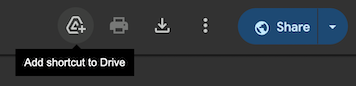

Скачаем данные для обучения и тестирования:

In [93]:
dataset = pd.read_csv('salary_dataset.csv')
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [94]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [95]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [96]:
counter = Counter()

for text in dataset.FullDescription:
    text = text.lower()  # преобразование текста в нижний регистр
    text = re.sub(r'\b(the)\b', '', text)  # удаление артикля
    text = re.sub(r'\s+', ' ', text)  # удаление лишних пробелов
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)

И ограничим размер словаря

In [97]:
MAX_VOCAB_SIZE = 25000
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [98]:
list(ordered_dict.items())[:10]

[('experience', 347792),
 ('role', 238264),
 ('work', 227972),
 ('team', 218265),
 ('business', 216163),
 ('skills', 191849),
 ('working', 181539),
 ('within', 177697),
 ('sales', 170534),
 ('client', 160978)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [99]:
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [100]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [101]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)

    texts_tensors = [torch.LongTensor(text) for text in texts]
    target = torch.FloatTensor(target)

    # дополним до макс. длины в батче
    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

In [102]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [103]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  25000, 25000, 25000, 146, 21, 25000, 25000, 25000, 25000, 38, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  25000, 9, 25000, 15, 25000, 25000, 407, 171, 129, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  25000, 25000, 25000, 25000, 832, 25000, 25000, 25000, 25000, 25000, ...
Таргет: 72098.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [104]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

(150000, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [105]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.0897, 0.0433, 0.1385, ...


Сформируйте даталоадеры для обучения и валидации.

In [106]:
BATCH_SIZE = 64  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

In [107]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens,
        emb_size=512,
        rnn_num_units=64,
        num_layers=2,
        output_dim=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        5) num_layers - число слоев LSTM
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(input_size=emb_size, hidden_size=rnn_num_units, 
                           batch_first=True, num_layers=num_layers)
        self.classifier = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """

        emb = self.emb(x)

        _, (h_state, _) = self.rnn(emb)

        predictions = self.classifier(h_state.squeeze(0))
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [108]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [109]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0
    model.train()

    for batch_id, batch in enumerate(iterator):
        optimizer.zero_grad()

        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        mse_cur_error = mse(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_mse += mse_cur_error.item()
        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0

    model.eval()

    with torch.no_grad():
        for batch_id, batch in enumerate(iterator):
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)

            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            mse_cur_error = mse(predictions, labels)

            epoch_loss += loss.item()
            epoch_mse += mse_cur_error.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [110]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

In [83]:
# Задайте параметры сети
model = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=512,
        rnn_num_units=64,
        output_dim=1).to(device)

# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

# Посмотрите на получившуюся модель
model

SimpleRNNRegressor(
  (emb): Embedding(25002, 512, padding_idx=25001)
  (rnn): LSTM(512, 64, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

Напишем код для сравнения качества на тестовой выборке - выведем ошибки и дополнительно сравним функции распределения зарплат

In [111]:
def plot_salary_distribution(model, valid_loader, scaler):
    def get_predictions(model, valid_loader):
        predictions = []
        model.eval()
        with torch.no_grad():
            for batch in valid_loader:
                texts, _ = batch
                texts = texts.to(device)
                output = model(texts).squeeze(1)
                predictions.append(output.cpu().numpy()[-1,:,:])
        return np.concatenate(predictions)

    def inverse_normalize(scaled_salaries, scaler):
        return scaler.inverse_transform(np.array(scaled_salaries).reshape(-1, 1)).flatten()

    predictions = get_predictions(model, valid_loader)
    predicted_salaries = inverse_normalize(predictions, scaler)
    
    sorted_predicted_salaries = np.sort(predicted_salaries)
    cumulative_sum_predicted = np.cumsum(sorted_predicted_salaries)
    true_salaries = inverse_normalize(valid_target_std, scaler)
    sorted_true_salaries = np.sort(true_salaries)

    cumulative_sum_true = np.cumsum(sorted_true_salaries)
    sns.set(style="darkgrid")

    mse_error = F.mse_loss(torch.tensor(predicted_salaries), torch.tensor(true_salaries)).item()
    mae_error = F.l1_loss(torch.tensor(predicted_salaries), torch.tensor(true_salaries)).item()
    mape_error = torch.mean(torch.abs(torch.tensor(true_salaries) - torch.tensor(predicted_salaries)) / torch.tensor(true_salaries)) * 100

    print(f"MSE: {mse_error:.2f}")
    print(f"MAE: {mae_error:.2f}")
    print(f"MAPE: {mape_error:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_predicted_salaries, cumulative_sum_predicted, color='blue', label='Предсказанные зарплаты')
    plt.plot(sorted_true_salaries, cumulative_sum_true, color='red', label='Настоящие зарплаты')
    plt.title('Функция распределения предсказанных и настоящих зарплат')
    plt.xlabel('Зарплата')
    plt.ylabel('Количество предсказаний с меньшей зарплатой')
    plt.legend()
    plt.xlim(0, 125000)
    plt.grid(True)
    plt.show()

**Первая модель:**

    model = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=512,
        rnn_num_units=64,
        output_dim=1).to(device)


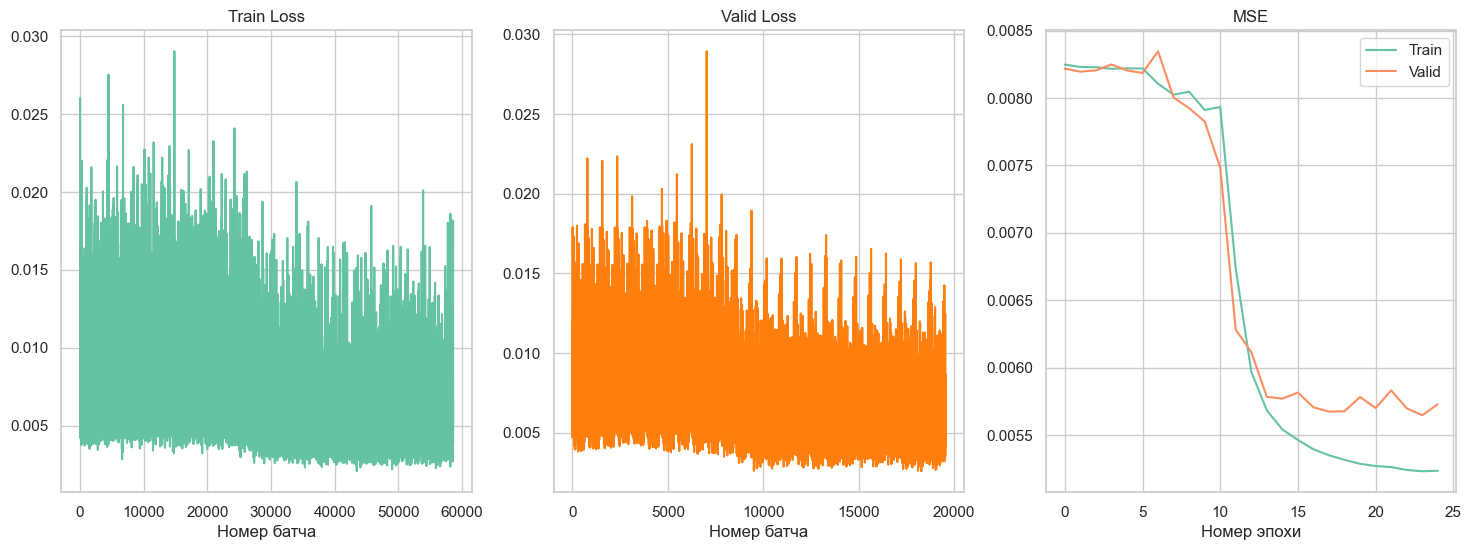

Номер эпохи: 25 | Время обучения эпохи: 2m 13s


In [23]:
training_loop(model_instance=model, n_epochs=25)

MSE: 120458775.02
MAE: 7275.24
MAPE: 22.24%


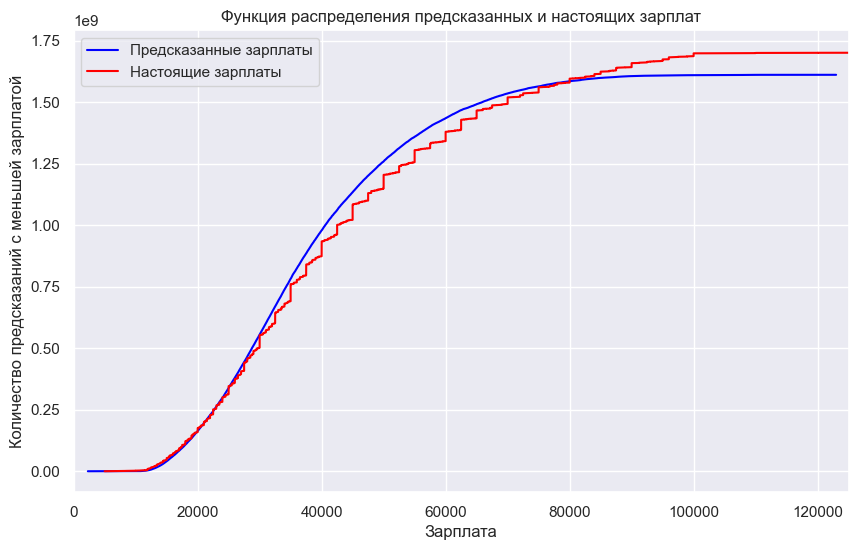

In [24]:
plot_salary_distribution(model, valid_loader, scaler)

**Вторая модель:**

    model_1 = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=256,
        rnn_num_units=8,
        output_dim=1, num_layers=5).to(device)

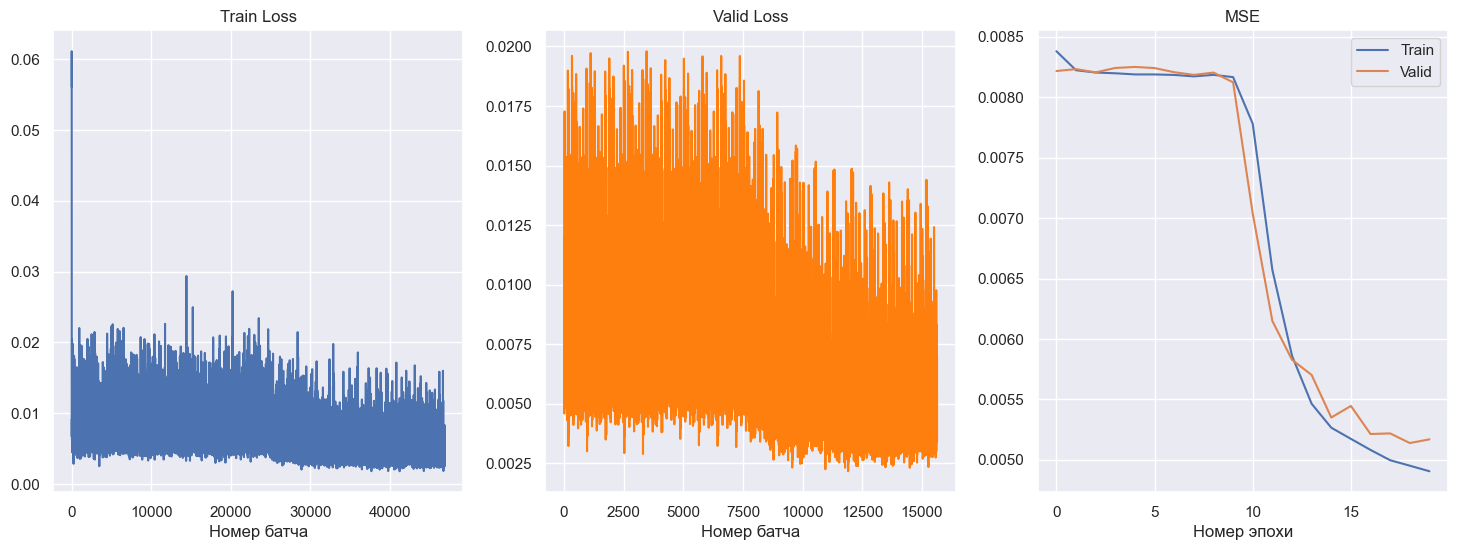

Номер эпохи: 20 | Время обучения эпохи: 1m 27s


In [119]:
model_1 = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=256,
        rnn_num_units=8,
        output_dim=1, num_layers=5).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.005)
history = []

training_loop(model_instance=model_1, n_epochs=20)

MSE: 167472213.48
MAE: 9359.17
MAPE: 32.25%


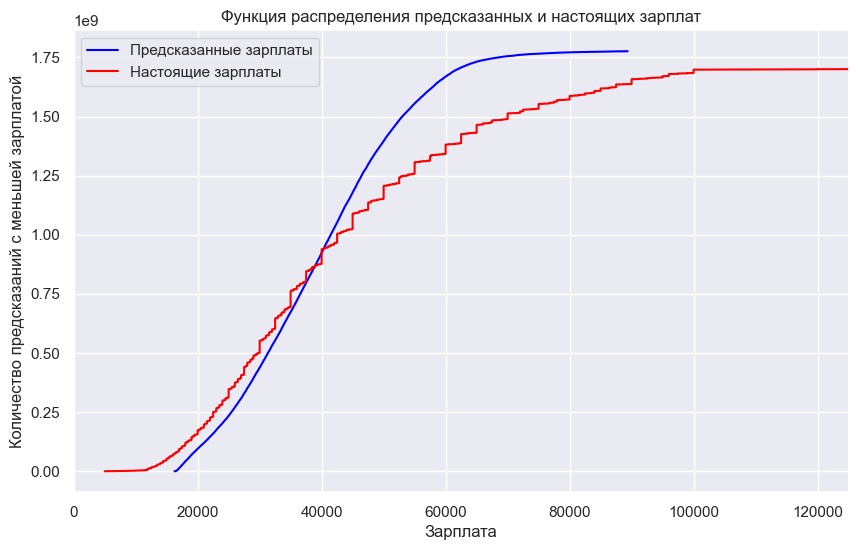

In [120]:
plot_salary_distribution(model_1, valid_loader, scaler)

**Третья модель:**

    model_2 = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=256,
        rnn_num_units=8,
        output_dim=1, num_layers=9).to(device)

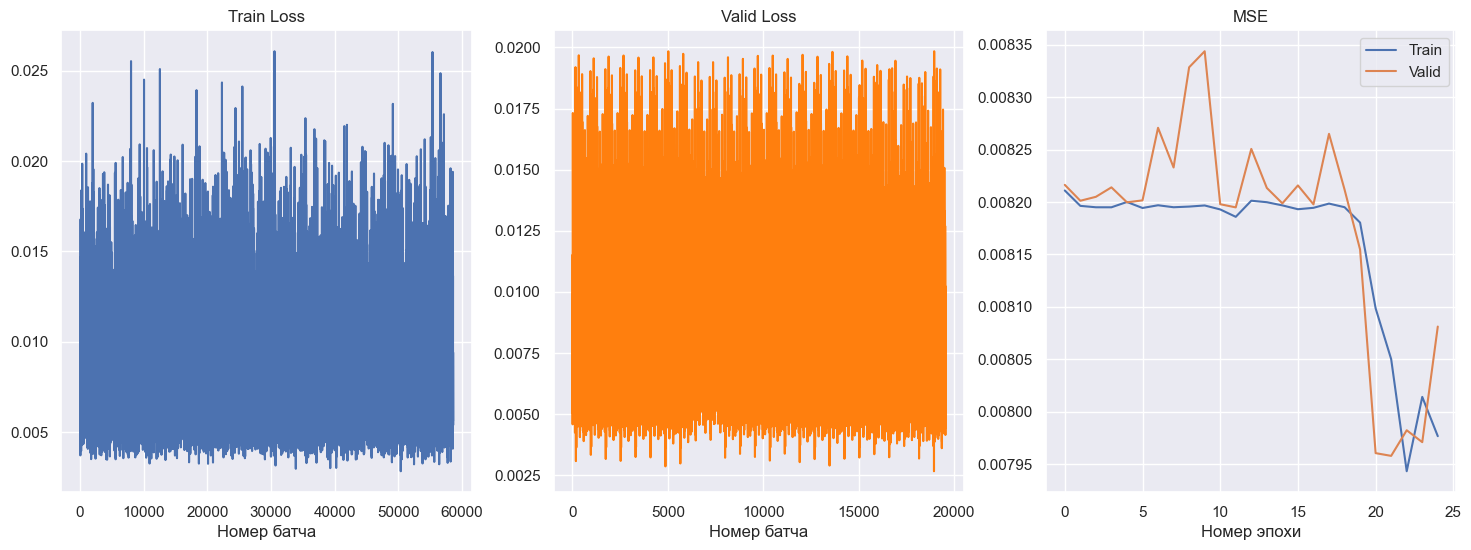

Номер эпохи: 25 | Время обучения эпохи: 1m 37s


In [134]:
model_2 = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=256,
        rnn_num_units=8,
        output_dim=1, num_layers=9).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.005)
history = []

training_loop(model_instance=model_2, n_epochs=25)

MSE: 305667868.00
MAE: 12708.77
MAPE: 43.43%


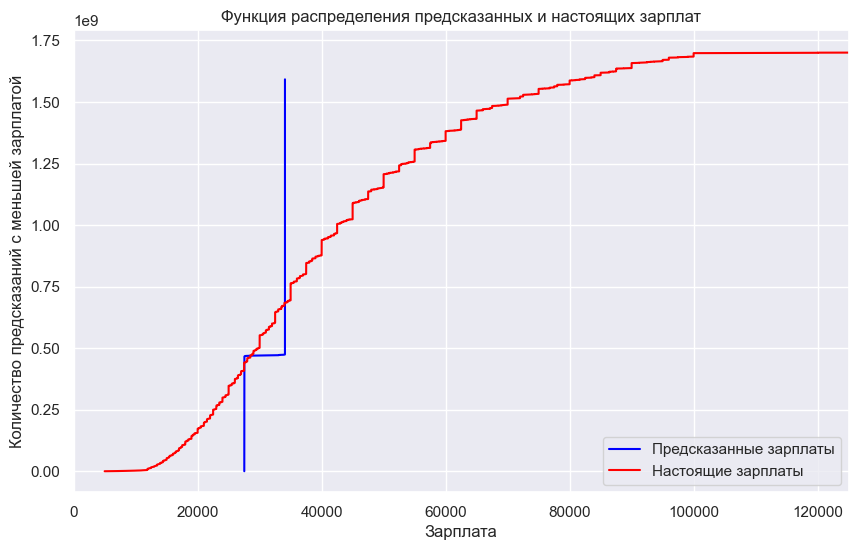

In [135]:
plot_salary_distribution(model_2, valid_loader, scaler)

**Четвертая модель:**

    model_3 = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=300,
        rnn_num_units=16,
        output_dim=1, num_layers=2).to(device)

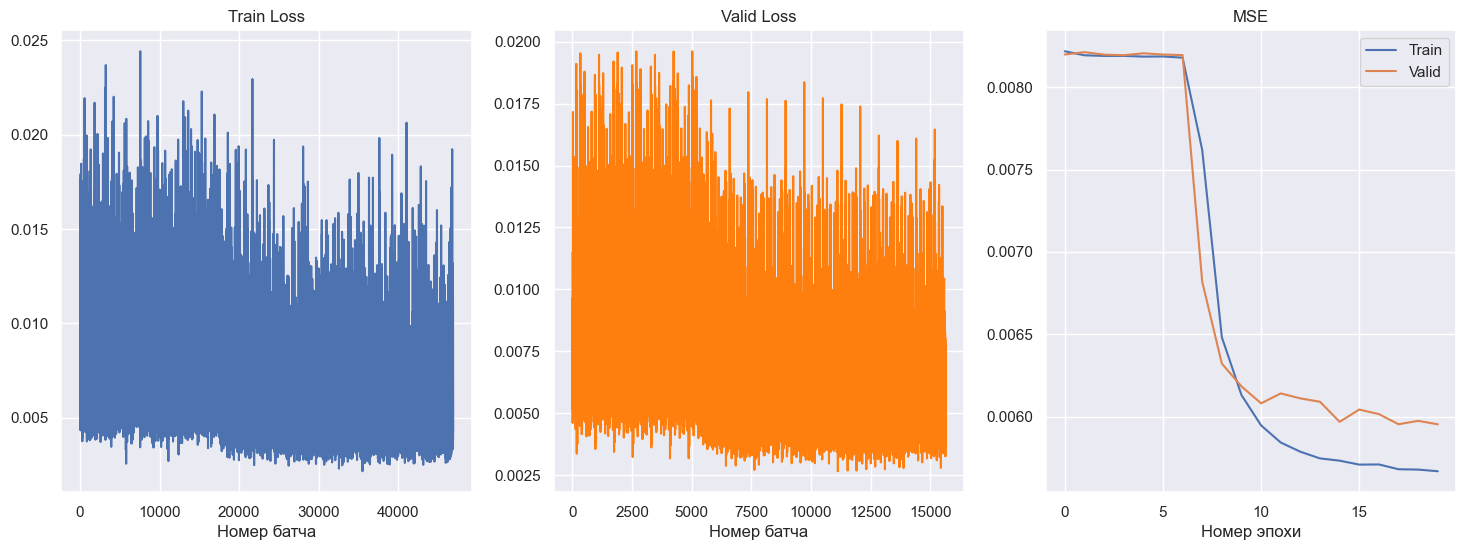

Номер эпохи: 20 | Время обучения эпохи: 1m 7s


In [123]:
model_3 = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=300,
        rnn_num_units=16,
        output_dim=1, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.005)
history = []

training_loop(model_instance=model_3, n_epochs=20)

MSE: 153806402.71
MAE: 8648.04
MAPE: 27.92%


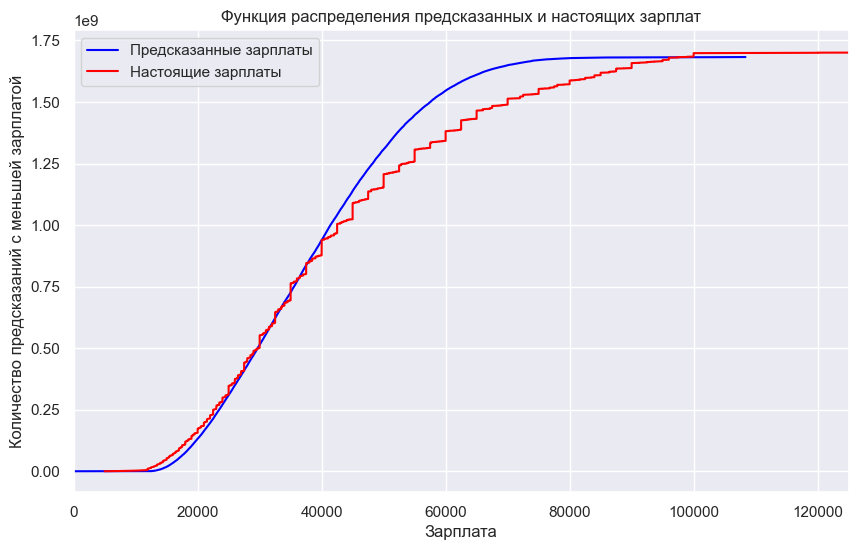

In [127]:
plot_salary_distribution(model_3, valid_loader, scaler)

**Пятая модель:**

    model_4 = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=300,
        rnn_num_units=16,
        output_dim=1, num_layers=5).to(device))

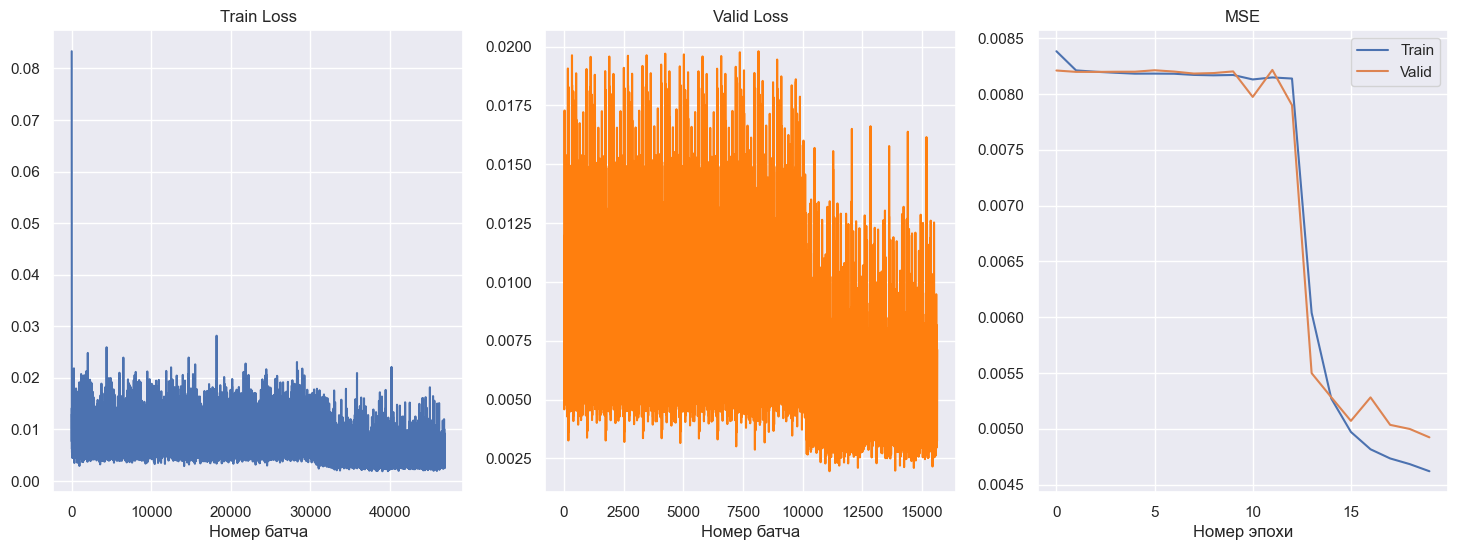

Номер эпохи: 20 | Время обучения эпохи: 1m 23s


In [124]:
model_4 = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=300,
        rnn_num_units=16,
        output_dim=1, num_layers=5).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.005)
history = []

training_loop(model_instance=model_4, n_epochs=20)

MSE: 155017932.45
MAE: 8741.32
MAPE: 28.75%


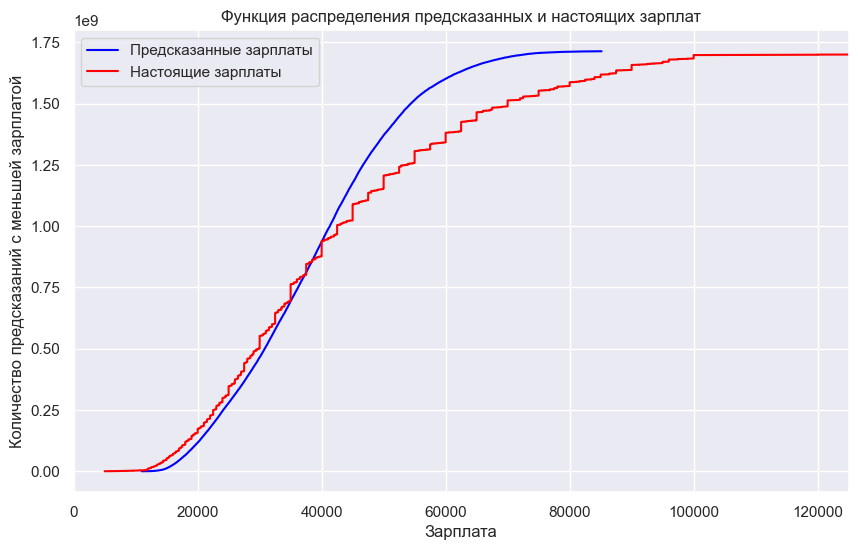

In [128]:
plot_salary_distribution(model_4, valid_loader, scaler)

**Шестая модель:**

    model_5 = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=512,
        rnn_num_units=8,
        output_dim=1, num_layers=8).to(device)

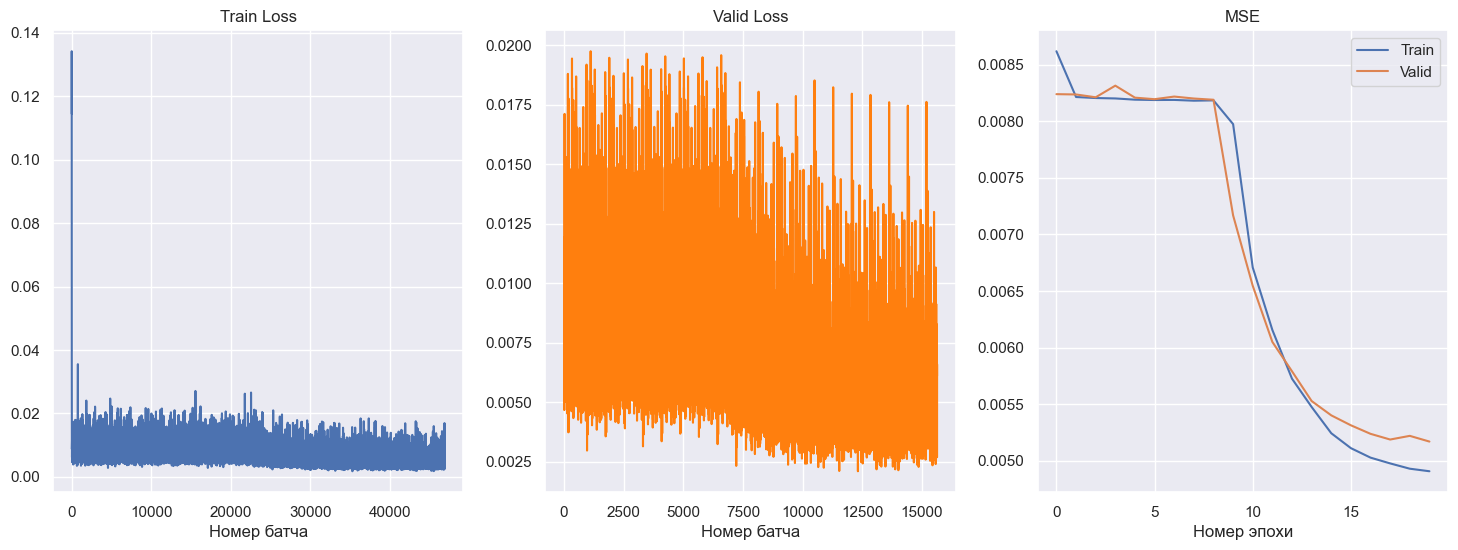

Номер эпохи: 20 | Время обучения эпохи: 2m 4s


In [126]:
model_5 = SimpleRNNRegressor(num_tokens=len(vocab),
        emb_size=512,
        rnn_num_units=8,
        output_dim=1, num_layers=8).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=0.005)
history = []

training_loop(model_instance=model_5, n_epochs=20)

MSE: 178971593.79
MAE: 9568.50
MAPE: 31.70%


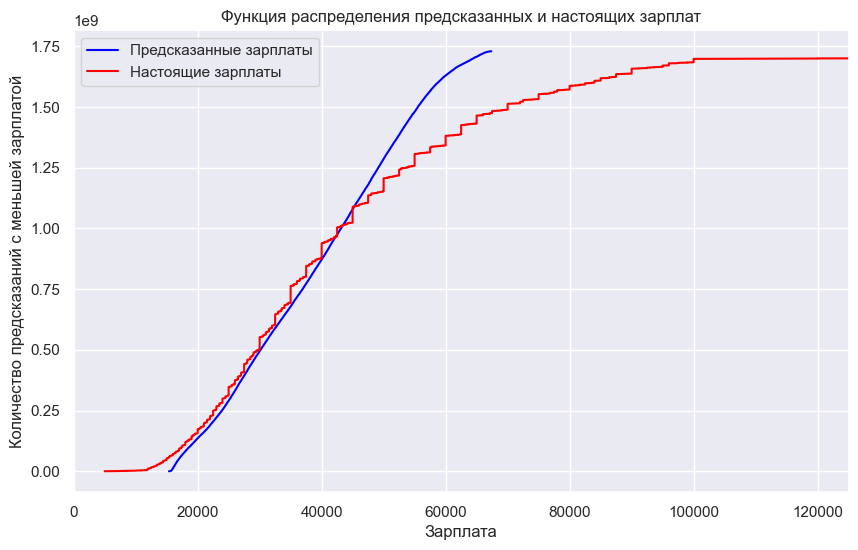

In [129]:
plot_salary_distribution(model_5, valid_loader, scaler)

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

In [149]:
def evaluate_model(model, scaler):
    def get_predictions(model, valid_loader):
        predictions = []
        model.eval()
        with torch.no_grad():
            for batch in valid_loader:
                texts, _ = batch
                texts = texts.to(device)
                output = model(texts).squeeze(1)
                predictions.append(output.cpu().numpy()[-1,:,:])
        return np.concatenate(predictions)

    def inverse_normalize(scaled_salaries, scaler):
        return scaler.inverse_transform(np.array(scaled_salaries).reshape(-1, 1)).flatten()

    predictions = get_predictions(model, valid_loader)
    predicted_salaries = inverse_normalize(predictions, scaler)
    true_salaries = inverse_normalize(valid_target_std, scaler)
    sns.set(style="darkgrid")

    mse_error = F.mse_loss(torch.tensor(predicted_salaries), torch.tensor(true_salaries)).item()
    mae_error = F.l1_loss(torch.tensor(predicted_salaries), torch.tensor(true_salaries)).item()
    mape_error = torch.mean(torch.abs(torch.tensor(true_salaries) - torch.tensor(predicted_salaries)) / torch.tensor(true_salaries)) * 100

    print(f"MSE: {mse_error:.2f}")
    print(f"MAE: {mae_error:.2f}")
    print(f"MAPE: {mape_error:.2f}%")

    examples_ind = np.random.choice(len(dataset.index), 10)
    
    with torch.no_grad():
        for idx in np.array(dataset.index)[examples_ind][:5]:
            text, target = dataset.loc[idx]
            tokens = vocab(tokenizer(text))
            tokens = torch.LongTensor(tokens).to(device)
            output = model(tokens).squeeze(1)
            pred = scaler.inverse_transform(output.cpu()[-1].reshape(1, -1))
            print(f'Вакансия: {text[:200]}...')
            print(f'Истинная зарплата: {target}')
            print(f'Предсказанная моделью: {int(pred.item())}\n' + '\n')

evaluate_model(model_3, scaler)

MSE: 153806402.71
MAE: 8648.04
MAPE: 27.92%
Вакансия: We need a Dynamics CRM Functional Business Analyst to work on a large multinational project. This is a long term ****  12 month contract that will be extended in to 2014. You must be a Dynamics CRM fu...
Истинная зарплата: 90000
Предсказанная моделью: 65523


Вакансия: d****CCK, Views, Panels, Modules, drupal Huntress Group are currently looking for a drupal developer for a major UK publisher for an initial 3 month contract. The ideal dev will be largely backend mod...
Истинная зарплата: 90000
Предсказанная моделью: 67622


Вакансия: We have a great opportunity to be part of a highly professional government department providing a valuable service to the general public. The role would involve using a high level of customer service ...
Истинная зарплата: 14700
Предсказанная моделью: 28579


Вакансия: FINTEC Recruit is seeking a Commercial Officer. Our client is an international engineering support organisation working in marine, oil a

**Вывод:**

Нам получилось обучить несколько RNN моделей. Несмотря на простоту своей архитектуры, мы достигаем точности (для четвертой модели):

    MSE: 153806402.71
    MAE: 8648.04
    MAPE: 27.92%

Что можно считать хорошим результатом. В ходе обучения моеделей можно заметить следующее: модели переобучаются к ~10 эпохе, характерным параметром модели является число слоев num_layers. Оптимальным значением можно считать 2-5, при высоких значениях модель плохо обучается. Параметр rnn_num_units не стоит делать слишком маленьким, оптимальное значение 16-64, при слишком маленьком значении машина имеет большую ошибку.